In [1]:
import pandas as pd
from collections import namedtuple, OrderedDict
import datetime
import ujson
import os
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import math
import time
import gzip
from utils import *  # helper functions

sns.set(font_scale=1.3)

LOGS = './logs/'
Window = namedtuple('Window', 'pid name start_time last_update focus_time exe cmd')
Event = namedtuple('Event', 'time category text index')

VBox(children=(HTML(value=''), IntProgress(value=0, max=683)))

In [2]:
privacy = True  # replace all category names with <REDACTED> when plotting

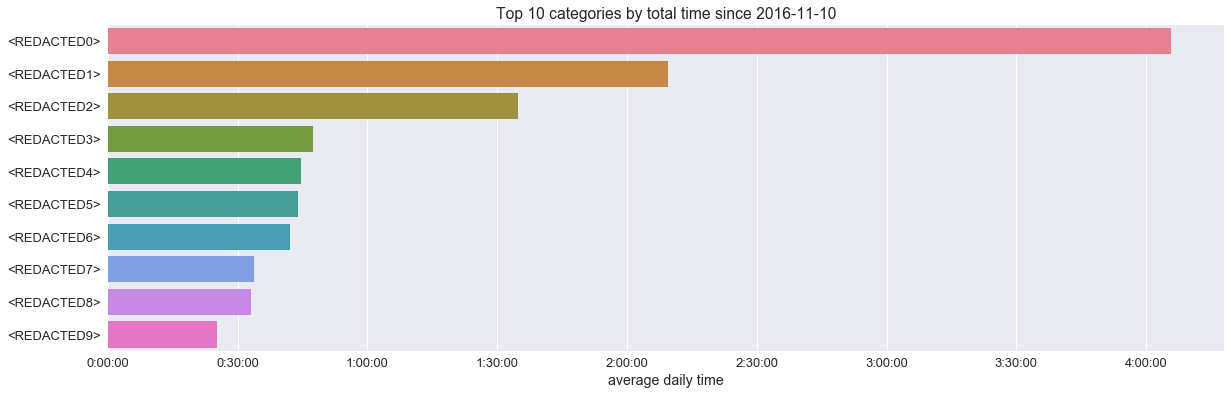

In [3]:
def plot_top_categories(category_count=None, starting_date=None):
    starting_date = clip_start_date(starting_date)
    data_after_starting_date = data[data.boot > starting_date]
    days_since_start = (pd.Timestamp.now() - starting_date).total_seconds() / 3600 / 24
    average_time = lambda x: timedelta_to_ms_hr(x) / days_since_start
    d = data_after_starting_date.groupby('category')['focus_time'].sum().apply(average_time)
    if category_count:
        d = d.sort_values(ascending=False)[:category_count]
    else:
        d[d>CUTOFF].sort_values(ascending=False)
    category_count = len(d.index)
    plt.figure(figsize=(20,6))
    if privacy: d.index = [f'<REDACTED{i}>' for i in range(category_count)]
    ax = sns.barplot(d.values, d.index, orient='h', palette=sns.color_palette('husl', category_count))
    ax.set_title('Top {} categories by total time since {}'.format(category_count, 
                                                                   starting_date.date()))
    ax.set_xlabel('average daily time')
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))
    
plot_top_categories(10, starting_date='2000-01-01')

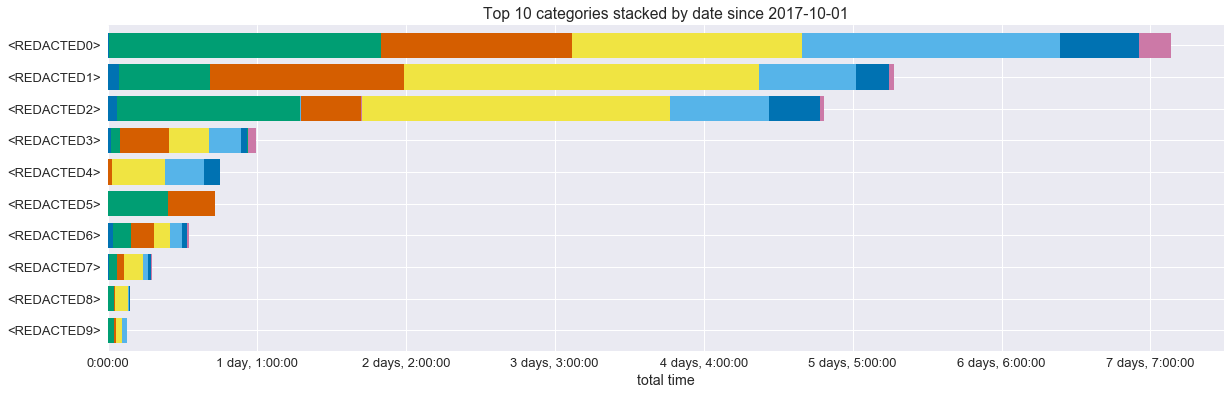

In [4]:
def plot_top_by_date(category_count=None, starting_date=None):
    d = total_time_by_category_boot(data)
    starting_date = clip_start_date(starting_date)
    d = d.T
    d = d[d.index > starting_date].T
    d = reindex_by_sum(d)
    if category_count:
        d = d[-category_count:]
    
    sns.set_palette('colorblind')
    if privacy: d.index = [f'<REDACTED{i}>' for i in reversed(range(category_count))]
    ax = d.plot.barh(stacked=True, figsize=(20,6), width=0.8, fontsize=13, legend=False)
    ax.set_title('Top {} categories stacked by date since {}'.format(category_count, 
                                                                     starting_date.date()))
    ax.set_xlabel('total time')
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))
    
#plot_top_by_date(15, '2016-01-01')
plot_top_by_date(10, starting_date='2017-10-01')
#plot_top_by_date(10)

32 days 18:05:01.635006


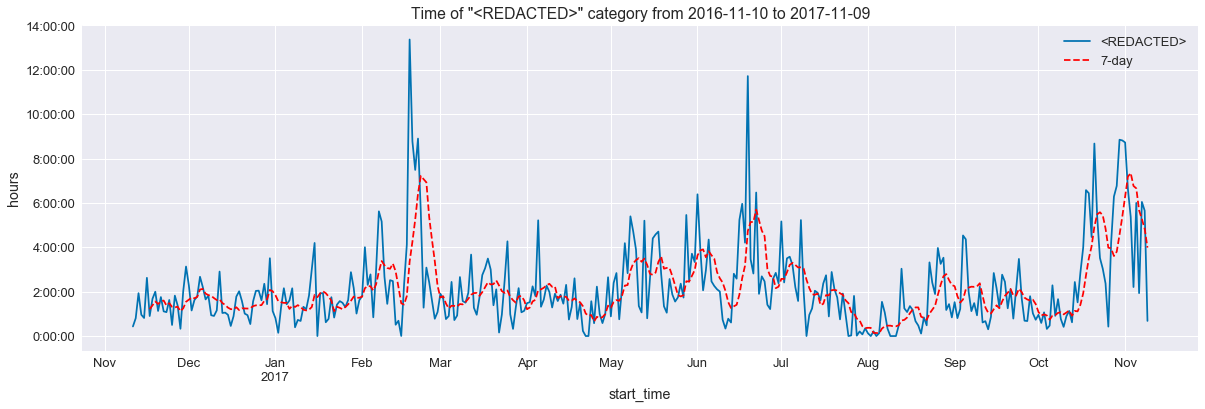

In [5]:
def plot_category_by_day(category, start_date=None, end_date=None):
    sns.set_palette('colorblind')
    start_date = clip_start_date(start_date)
    end_date = clip_end_date(end_date)
    d = data[(data['boot'] > pd.Timestamp(start_date)) & (data['boot'] <= pd.Timestamp(end_date))]
    print(d[(d['category'] == category)].focus_time.sum())
    d = total_time_by_category_day(d).fillna(0.0) # SLOW
    #d = total_time_by_category_boot(d).fillna(0.0)
    d2 = d.query("category == '{}'".format(category)).dropna(1).T
    if privacy: d2.columns = ['<REDACTED>']
    ax = d2.plot(figsize=(20,6))
    rolling_mean = d[d.index == category].T.resample('D').sum().fillna(0.0).rolling(7).mean()
    rolling_mean.columns = ['7-day']
    rolling_mean.plot(ax=ax, style='r--')
    if privacy: category = '<REDACTED>'
    ax.set_title('Time of "{}" category from {} to {}'.format(category, start_date.date(), end_date.date()))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))
    ax.set_ylabel('hours')

plot_category_by_day('<REDACTED>', start_date='2014-07-01')  # category manually redacted

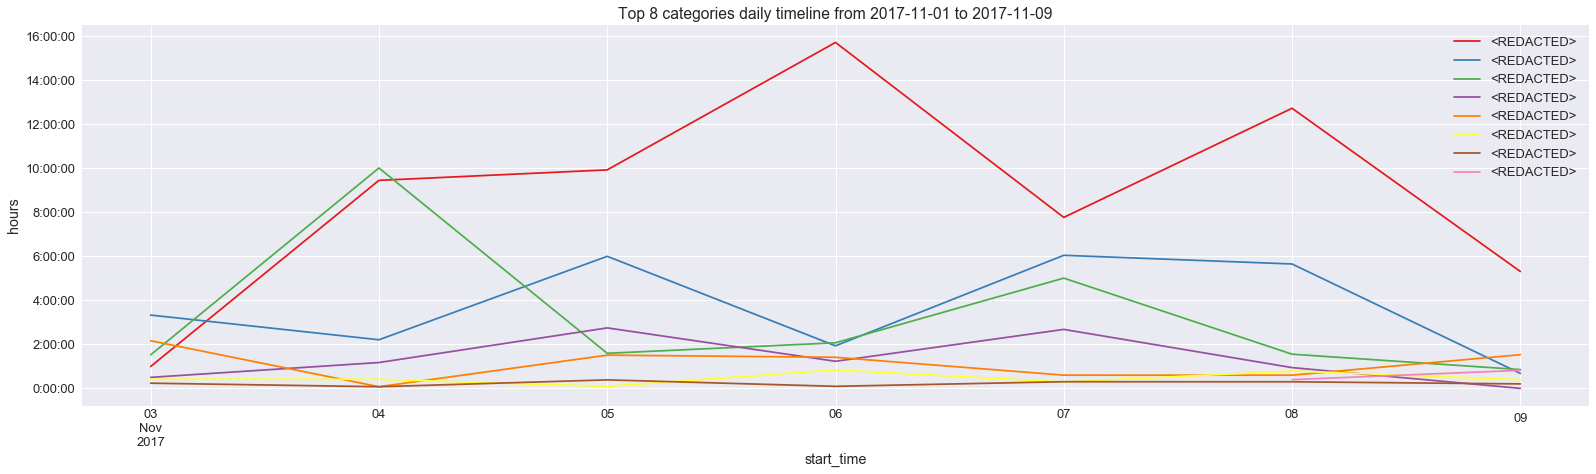

In [6]:
def plot_timeline_by_category_time(category_count, start_date=None, end_date=None):
    sns.set_palette('Set1', int(category_count*1.2))
    start_date = max(data.start_time.min(), pd.Timestamp(start_date))
    end_date = min(data.start_time.max(), pd.Timestamp(end_date))
    d = data[(data['boot'] > pd.Timestamp(start_date)) 
             & (data['boot'] <= pd.Timestamp(end_date))]
    categories = top_categories_index(d, category_count)
    d = d.set_index('start_time') \
        .groupby('category') \
        .resample('D')['focus_time'].sum() \
        .apply(timedelta_to_ms_hr) \
        .unstack(level=0)[categories]
    ##d = d.groupby(['category', 'boot']).focus_time.sum().unstack(0)
    ##d = d[categories].resample('D').sum().fillna(pd.Timedelta(0)).apply(timedelta_to_ms_hr)
    #for i in range(category_count):
    #ax = d.iloc[:,i].plot(figsize=(27,7), x_compat=False, label=d.columns[i])
    if privacy: d.columns = ['<REDACTED>']*category_count
    ax = d.plot(figsize=(27,7), x_compat=False)
    ax.set_title('Top {} categories daily timeline from {} to {}'.format(category_count, 
                                                                         start_date.date(), 
                                                                         end_date.date()))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(time_ticks))
    ax.xaxis.grid(True, which="minor")
    ax.set_ylabel('hours')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plot_timeline_by_category_time(8, start_date='2017-11-01', end_date='2020-01-01')

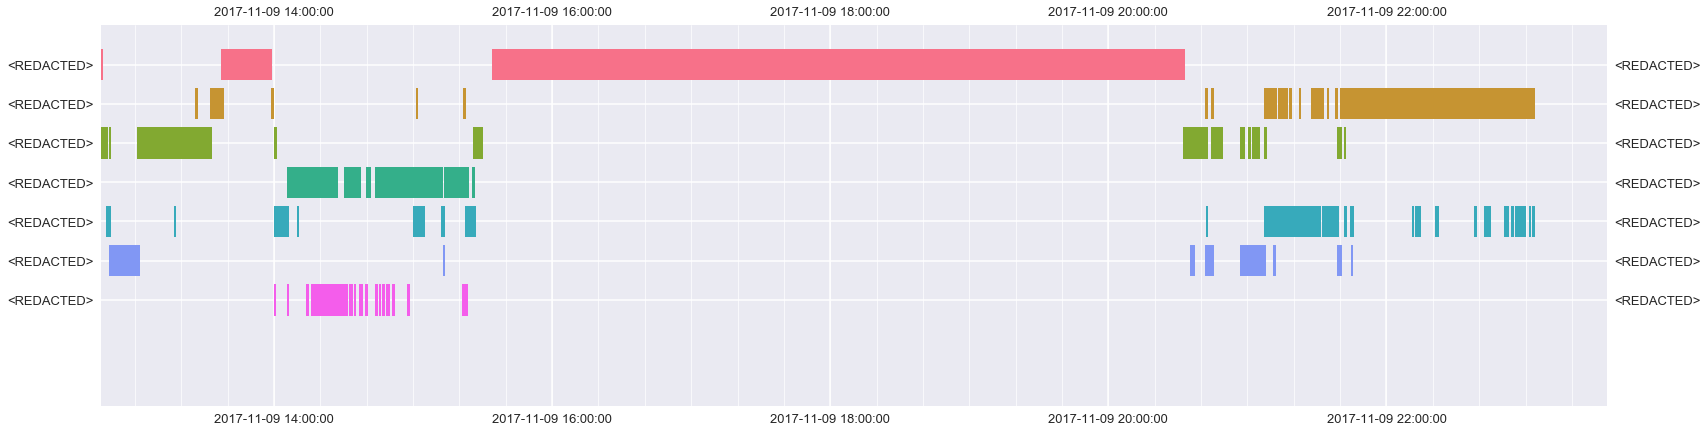

In [7]:
def plot_day_sequence_chart(category_count, date=None):
    import utils  # need to pass variables back to utils
    def add_event_vline(event):
        pos = timedelta_to_ms_hr(event.time - boot_time_round)
        y = -1.3
        plt.axvline(pos, color=palette[sequence_categories.index(event.category)])
        plt.text(pos, -1-0.7*(event.index%3), event.text, rotation=0, fontsize=13)

    files = {file : os.path.getctime(os.path.join(LOGS, file)) for file in os.listdir(LOGS)}        
    today = pd.Timestamp(date).date() if date else (dt.fromtimestamp(files[sorted(files.keys())[-1]]) 
                                                    - pd.Timedelta('6 hours')).date()
    day = sum([load(os.path.join(LOGS, k)) for k, v in files.items() 
               if (dt.fromtimestamp(v) - pd.Timedelta('6 hours')).date() == today], [])
    day = pd.DataFrame.from_records(day, columns=Window._fields)
    day['focus_time'] = day['focus_time'].apply(lambda x : pd.Timedelta(x))
    day['start_time'] = day['start_time'].apply(lambda x : pd.Timestamp(x))
    day['last_update'] = day['last_update'].apply(lambda x : pd.Timestamp(x))
    day['category'] = merge(day['name'].apply(lambda x: categorize(x, categories_name)).values, 
                             day['exe'].apply(lambda x: categorize(x, categories_exe)).values,
                             day['exe'].str.split('\\').apply(lambda x: x[-1]).values)
    sequence_categories = list(reversed(list(top_categories_index(day, category_count))))
    utils.sequence_categories = sequence_categories
    
    day_aggregate = day.groupby(['pid', 'name', 'start_time']).agg({'focus_time' : sum, 
                                                                    'last_update' : max, 
                                                                    'exe' : max, 
                                                                    'cmd': max, 
                                                                    'category':max})
    data = day_aggregate.reset_index().sort_values('focus_time', ascending=False)

    d = day.set_index('category')[['focus_time', 'last_update']]
    d['start_time'] = d['last_update'] - d['focus_time']
    d['focus_time'] = d['focus_time'].apply(timedelta_to_ms_hr)
    d = d.sort_values('start_time')
    boot_time = day['start_time'].min()
    boot_time_round = boot_time.replace(minute=0, second=0)
    utils.boot_time_round = boot_time_round
    
    fig = plt.figure(figsize=(27,7))
    ax = fig.add_subplot(111)
    palette = list(reversed(sns.color_palette('husl', category_count)))
    
    pad = 60*1000/3.6  # 60sec = expand length of event for quick events
    stitch = 60*1000/3.6 # 60sec = events with a (gap < stitch) become one

    # stitching
    d2 = []
    for category in set(d.index):
        group = d[d.index == category].reset_index()
        stime = group.iloc[0].start_time
        ltime = group.iloc[0].last_update
        lg = len(group)
        if lg==1:
            d2.append(pd.Series(index=['start_time', 'last_update', 'focus_time'], name=category,
                     data=[stime, ltime, timedelta_to_ms_hr(ltime - stime)]))
        group['gap'] = timedelta_to_ms_hr(group['start_time'] - group.shift(1)['last_update'])
        for row in range(1, lg+1):
            if row==lg or (group.iloc[row].gap > stitch and row < lg):
                d2.append(pd.Series(index=['start_time', 'last_update', 'focus_time'], 
                                    name=category,
                                    data=[stime, 
                                          group.iloc[row-1].last_update, 
                                          timedelta_to_ms_hr(group.iloc[row-1].last_update - stime)]))
                if row < lg:
                    stime = group.iloc[row].start_time
    d2 = pd.DataFrame(d2)

    # plotting
    for row in range(len(d2)):
        if d2.index[row] in sequence_categories:
            # pad to the left and to the right to reduce noise
            category = sequence_categories.index(d2.index[row])
            #print(d2.index[row])
            #print(d2.loc[:, 'focus_time'].iloc[row])
            ax.barh(y=sequence_categories.index(d2.index[row]), 
                    width=d2.loc[:, 'focus_time'].iloc[row]+pad, 
                    height=.8, 
                    left=timedelta_to_ms_hr(d2.loc[:, 'start_time'].iloc[row] - boot_time_round) - pad, 
                    align='center', 
                    color=palette[category],
                    edgecolor = 'none')

    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(date_boot_ticks))
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(label_ticks))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(6))
    ax.tick_params(labelright=True, labeltop=True)
    ax.grid(b=True, which='minor', color='w', linewidth=0.7)
    ax.grid(b=True, which='major', color='w', linewidth=1.5)
    ax.set_yticks(range(len(sequence_categories)))
    ax.set_yticklabels(sequence_categories)
    if privacy: ax.set_yticklabels(['<REDACTED>']*len(sequence_categories))
    ax.set_ylim(-2.7, len(sequence_categories))

    # plot 'todo' category events as vertical lines, color by category with most time in +-10min
    event_delta = pd.Timedelta('10min')
    todos = data[data['category'] == 'todo'].sort_values('last_update')
    for i, (_, event_row) in enumerate(todos.iterrows()):
        if event_row['last_update'] > pd.Timestamp('2016-05-28 17:00'):
            event_time = event_row['last_update'] - event_row['focus_time'] 
            intersections = day[(event_time - event_delta < day['last_update'] - day['focus_time']) & 
                                (day['last_update'] - day['focus_time'] < event_time + event_delta) | 
                                (event_time - event_delta < day['last_update']) & 
                                (day['last_update'] < event_time + event_delta) | 
                                (day['last_update'] - day['focus_time'] < event_time) & 
                                (event_time < day['last_update'])]
            category = intersections.groupby('category')['focus_time'].sum().idxmax()        
            add_event_vline(Event(event_time, category, event_row['name'].split('- TODO')[0], i))

plot_day_sequence_chart(7)